In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from collections import OrderedDict
import matplotlib.pyplot as plt
# Extras
from matplotlib.patches import FancyArrowPatch

from utils import *

### Device setup

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


### Base network construction

In [3]:
class Base_Wasser_NN(nn.Module):
    def __init__(self, n: int, d: int):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(OrderedDict([
            ('Lin1', nn.Linear(2 * n * d, 4* n * d)),
            ('relu1', nn.ReLU()),
            ('Lin2', nn.Linear(4* n * d, n * n + 2 * n))  # n x n matrix and two n-long vectors
        ]))

    def forward(self, batch):
        flattened_batch = self.flatten(batch)
        vs1 = flattened_batch[0]
        vs2 = flattened_batch[1]
        x= torch.cat((vs1, vs2), dim=0)
        logits = self.linear_relu_stack(x)
        return logits
    def predict_interval(self,batch):
        vecs1 = batch[0]  # Shape: (n, d)
        vecs2 = batch[1]  # Shape: (n, d)

        # Compute distance matrix
        distances_mat = compute_distance_matrix(vecs1=vecs1, vecs2=vecs2)
        pred = self.forward(batch)
        # Ensure that pred is the correct size for n
        assert pred.shape[0] == n * n + 2 * n, "Prediction tensor does not have the expected size."

        # Reshape pred into the n x n matrix for outputs
        out_put_mat = pred[:n*n].view(n, n)  # Shape: (n, n)
        f = pred[n*n:n*n+n]  # Shape: (n,)
        g = pred[n*n+n:]     # Shape: (n,)

        # Compute primal and dual solutions
        sol_prim = primal_sol(out_put_mat=out_put_mat, distances_mat=distances_mat)
        sol_dual = dual_sol(f=f,g=g,distances_mat=distances_mat)
        # Debug
        # print(f"sol_prim: {sol_prim.item()}, sol_dual: {sol_dual.item()}")
        
        return torch.tensor([sol_dual,sol_prim])


### Data Generation and formatting

In [4]:
from sklearn.model_selection import train_test_split

def generate_train_test_split(count: int, dim: int, n: int, device: torch.device, coord_max: float, test_size: float = 0.2, seed: int = 42):
    """
    Generates vector batches and performs a train-test split.

    Parameters:
    - count (int): Number of batches to generate.
    - dim (int): Dimension of each vector.
    - n (int): Number of vectors in each batch.
    - device (torch.device): The device on which to create the tensors.
    - coord_max (float): The maximum absolute value for each coordinate.
    - test_size (float): The proportion of the dataset to include in the test split.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - train_batches: A tensor with shape (train_count, 2, n, dim).
    - test_batches: A tensor with shape (test_count, 2, n, dim).
    """
    # Generate all vector batches
    all_batches = generate_vector_batches(count, dim, n, device, coord_max, seed)

    # Prepare the labels (not used directly, but can be if you add supervised learning context)
    labels = torch.arange(count)  # Placeholder for labels, if needed
    
    # Perform train-test split
    train_indices, test_indices = train_test_split(range(count), test_size=test_size, random_state=seed)

    # Index into the generated batches
    train_batches = all_batches[train_indices]
    test_batches = all_batches[test_indices]

    return train_batches, test_batches

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
count = 1000  # Total number of batches to generate
dim = 3      # Dimension of each vector
n = 4        # Number of vectors in each batch
coord_max = 5.0  # Maximum coordinate value
test_size = 0.2  # 20% of the data for testing

train_batches, test_batches = generate_train_test_split(count, dim, n, device, coord_max, test_size)

print("Train Batches Shape:", train_batches.shape)  # Should be (train_count, 2, n, dim)
print("Test Batches Shape:", test_batches.shape)    # Should be (test_count, 2, n, dim)


Train Batches Shape: torch.Size([800, 2, 4, 3])
Test Batches Shape: torch.Size([200, 2, 4, 3])


### Loss setup

In [5]:
def compute_distance_matrix(vecs1, vecs2):
    """
    Computes the pairwise distance matrix between two sets of vectors.

    Parameters:
    - vecs1: Tensor of shape (n, d), where n is the number of vectors and d is the dimension of each vector.
    - vecs2: Tensor of shape (n, d), where m is the number of vectors and d is the dimension of each vector.

    Returns:
    - distance_matrix: Tensor of shape (n, n), where each element [i, j] represents the Euclidean distance between vecs1[i] and vecs2[j].
    """
    # Compute the pairwise distance matrix using torch.cdist (Euclidean distance by default)
    distance_matrix = torch.cdist(vecs1, vecs2, p=2)
    
    return distance_matrix


def make_wass_loss(n: int, d: int):
    def wass_loss(batch, pred):
        # Unpack vectors from the batch
        vecs1 = batch[0]  # Shape: (n, d)
        vecs2 = batch[1]  # Shape: (n, d)

        # Compute distance matrix
        distances_mat = compute_distance_matrix(vecs1=vecs1, vecs2=vecs2)

        # Ensure that pred is the correct size for n
        assert pred.shape[0] == n * n + 2 * n, "Prediction tensor does not have the expected size."

        # Reshape pred into the n x n matrix for outputs
        out_put_mat = pred[:n*n].view(n, n)  # Shape: (n, n)
        f = pred[n*n:n*n+n]  # Shape: (n,)
        g = pred[n*n+n:]     # Shape: (n,)
        
        # Compute primal and dual solutions
        sol_prim = primal_sol(out_put_mat=out_put_mat, distances_mat=distances_mat)
        sol_dual = dual_sol(f=f,g=g,distances_mat=distances_mat)
        # Debug
        # print(f"sol_prim: {sol_prim.item()}, sol_dual: {sol_dual.item()}")
        
        return sol_prim - sol_dual
        
    return wass_loss

def make_primal_loss(n: int, d: int):
    def primal_loss(batch, pred):
        # Unpack vectors from the batch
        vecs1 = batch[0]  # Shape: (n, d)
        vecs2 = batch[1]  # Shape: (n, d)

        # Compute distance matrix
        distances_mat = compute_distance_matrix(vecs1=vecs1, vecs2=vecs2)

        # Ensure that pred is the correct size for n
        assert pred.shape[0] == n * n + 2 * n, "Prediction tensor does not have the expected size."

        # Reshape pred into the n x n matrix for outputs
        out_put_mat = pred[:n*n].view(n, n)  # Shape: (n, n)
        f = pred[n*n:n*n+n]  # Shape: (n,)
        g = pred[n*n+n:]     # Shape: (n,)
        
        # Compute primal and dual solutions
        sol_prim = primal_sol(out_put_mat=out_put_mat, distances_mat=distances_mat)
        sol_dual = dual_sol(f=f,g=g,distances_mat=distances_mat)
        # Debug
        # print(f"sol_prim: {sol_prim.item()}, sol_dual: {sol_dual.item()}")
        
        return sol_prim
        
    return primal_loss

def make_dual_loss(n: int, d: int):
    def dual_loss(batch, pred):
        # Unpack vectors from the batch
        vecs1 = batch[0]  # Shape: (n, d)
        vecs2 = batch[1]  # Shape: (n, d)

        # Compute distance matrix
        distances_mat = compute_distance_matrix(vecs1=vecs1, vecs2=vecs2)

        # Ensure that pred is the correct size for n
        assert pred.shape[0] == n * n + 2 * n, "Prediction tensor does not have the expected size."

        # Reshape pred into the n x n matrix for outputs
        out_put_mat = pred[:n*n].view(n, n)  # Shape: (n, n)
        f = pred[n*n:n*n+n]  # Shape: (n,)
        g = pred[n*n+n:]     # Shape: (n,)
        
        # Compute primal and dual solutions
        sol_prim = primal_sol(out_put_mat=out_put_mat, distances_mat=distances_mat)
        sol_dual = dual_sol(f=f,g=g,distances_mat=distances_mat)
        # Debug
        # print(f"sol_prim: {sol_prim.item()}, sol_dual: {sol_dual.item()}")
        
        return wass_hungarian(batch = batch)-sol_dual
        
    return dual_loss

### Minor test

In [6]:
def train_model(model, train_batches, loss_fn, optimizer):
    """
    Train the model on the provided training batches.

    Parameters:
    - model: The neural network model to train.
    - train_batches: Tensor containing training batches of shape (count, 2, n, d).
    - loss_fn: The loss function.
    - optimizer: The optimizer for model parameters.
    """
    model.train()  # Set the model to training mode
    for i, batch in enumerate(train_batches):  # Iterate over all training batches
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        logits = model(batch)  # Model output

        
        # Assuming that `batch` contains two tensors for the Wasserstein loss
        loss = loss_fn(batch, logits)  # Compute the loss
        
        # Backward pass
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters



def test_model(model, test_batches, loss_fn):
    """
    Evaluate the model on the provided testing batches.

    Parameters:
    - model: The neural network model to evaluate.
    - test_batches: Tensor containing testing batches of shape (count, 2, n, d).
    - loss_fn: The loss function.
    
    Returns:
    - avg_loss: Average loss on the test set.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(test_batches):  # Iterate over all test batches
            # Flatten the batch to the expected input shape
            batch_flattened = batch.view(batch.size(0), -1)  # Shape: (batch_size, 2 * n * d)

            logits = model(batch_flattened)  # Model output
            
            loss = loss_fn(batch, logits)  # Compute the loss
            total_loss += loss.item()

    avg_loss = total_loss / len(test_batches)
    return avg_loss

# Define the parameters
count = 1000  # Number of batches
d = 2         # Dimension of each vector
n = 4         # Number of vectors in each batch
seed = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
coords_max = 3
# Generate train and test batches
train_batches, test_batches = generate_train_test_split(
    count=count,
    dim=d,
    n=n,
    device=device,
    coord_max=coords_max,
    test_size=0.2,
    seed=seed
)

# Create Loss function
# loss_fn = make_wass_loss(n=n, d=d)
loss_fn = make_primal_loss(n=n, d=d)
# loss_fn = make_dual_loss(n=n,d=d)

# Model instance
model = Base_Wasser_NN(n=n, d=d).to(device)
lr = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
print(model)
# Training and Testing Loop
epochs = 100
for t in range(epochs):
    if(t%3==2):
        print(f"Epoch {t + 1}\n-------------------------------")
    train_model(model, train_batches, loss_fn, optimizer)  # Training
    avg_loss = test_model(model, test_batches, loss_fn)  # Testing
    if(t%3==2):
        print(f'Average Test Loss: {avg_loss:.4f}')

print("Done!")


Base_Wasser_NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (Lin1): Linear(in_features=16, out_features=32, bias=True)
    (relu1): ReLU()
    (Lin2): Linear(in_features=32, out_features=24, bias=True)
  )
)
Epoch 3
-------------------------------
Average Test Loss: 6.8214
Epoch 6
-------------------------------
Average Test Loss: 6.8042
Epoch 9
-------------------------------
Average Test Loss: 6.7849
Epoch 12
-------------------------------
Average Test Loss: 6.7635
Epoch 15
-------------------------------
Average Test Loss: 6.7401
Epoch 18
-------------------------------
Average Test Loss: 6.7149
Epoch 21
-------------------------------
Average Test Loss: 6.6879
Epoch 24
-------------------------------
Average Test Loss: 6.6586
Epoch 27
-------------------------------
Average Test Loss: 6.6276
Epoch 30
-------------------------------
Average Test Loss: 6.5955
Epoch 33
-------------------------------
Average Test Loss: 6.5631
Epoch 36
--------

In [7]:
print("Interval: " ,model.predict_interval(test_batches[0]))
print("Actual Wasserstein Distance: ",wass_hungarian(test_batches[0]))
print("Interval: " ,model.predict_interval(test_batches[12]))
print("Actual Wasserstein Distance: ",wass_hungarian(test_batches[12]))

Interval:  tensor([0.1255, 7.5959])
Actual Wasserstein Distance:  tensor(6.4574, device='cuda:0')
Interval:  tensor([3.2128, 3.8726])
Actual Wasserstein Distance:  tensor(3.7077, device='cuda:0')


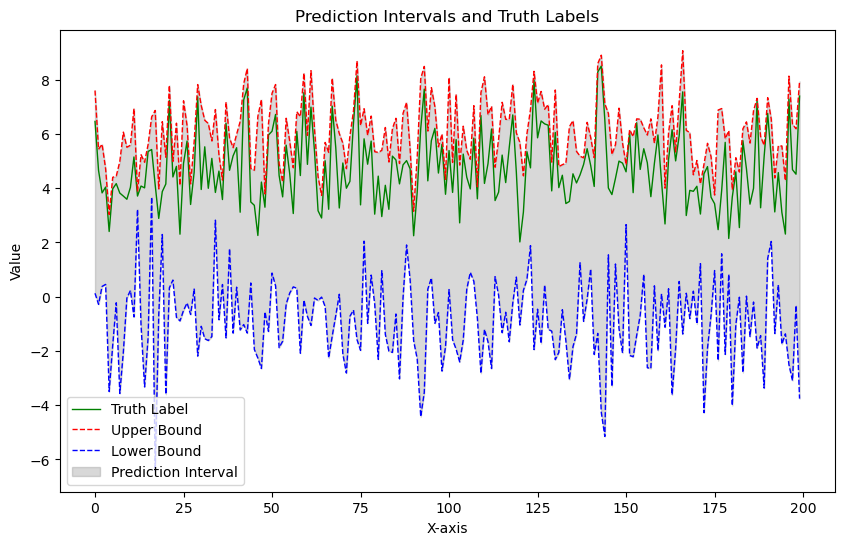

In [8]:
model.eval()
preds = []
with torch.no_grad():
    for i, batch in enumerate(test_batches):  # Iterate over all test batches
        # Flatten the batch to the expected input shape
        batch_flattened = batch.view(batch.size(0), -1)  # Shape: (batch_size, 2 * n * d)
        preds.append(model.predict_interval(batch))
        
x = range(len(test_batches))  # x-axis values (can be indices or actual values)
primal_bounds = [pred[1].cpu() for pred in preds]
dual_bounds = [pred[0].cpu() for pred in preds]
true_label = [wass_hungarian(input).cpu() for input in test_batches]         # True label (ground truth)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, true_label, label='Truth Label', color='green', linewidth=1)
plt.plot(x, primal_bounds, label='Upper Bound', color='red', linestyle='--', linewidth=1)
plt.plot(x, dual_bounds, label='Lower Bound', color='blue', linestyle='--', linewidth=1)

# Shading the area between the lower and upper bounds
plt.fill_between(x, dual_bounds, primal_bounds, color='gray', alpha=0.3, label='Prediction Interval')

# Labels and legend
plt.xlabel('X-axis')
plt.ylabel('Value')
plt.title('Prediction Intervals and Truth Labels')
plt.legend()

# Show the plot
plt.show()
